In [3]:
from data.datahandler import datahandler
from data.datareader import datareader
from models.QCNN import *
from utils import test_loader
from utils.plotter import *
from utils.converter import convert_labels_mapper

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load processed dataset

Instructions
1. the dataset should be placed in the working directory, specifically in the **datasets** folder.
2. the dataset should be already divided into classes, one-subfolder for earch classes. The folder/class name will be used to encode the label

If this script is runned after *Quantum Convolution Processing.ipynb* the folder structure should be alredy ready.

```
QuantumCNN
│   README.md
│   requirements.txt    
│
└───circuits
└───...
└───datasets
    └───EuroSAT
        └───Highway
                highway1.jpg
                highway2.jpg                
        └─── ....
        └───Lake
                lake1.jpg
                lake2.jpg                

```

Given *the dataset_name*, that must be the same of the folder, the **datahandler** will take care of loading the paths of the feature smaps and collected them into a class dictionary. After a report of the dataset will be printed.

In [14]:
dataset_name = 'EuroSAT_processed'
root = os.path.join('datasets', dataset_name)
dhandler = datahandler(root)
dhandler.print_report(name=dataset_name)

Dataset EuroSAT_processed

Class 0 - Forest                    - #images: 15
Class 1 - River                     - #images: 0
Class 2 - Highway                   - #images: 0
Class 3 - AnnualCrop                - #images: 0
Class 4 - SeaLake                   - #images: 0
Class 5 - HerbaceousVegetation      - #images: 0
Class 6 - Industrial                - #images: 0
Class 7 - Residential               - #images: 0
Class 8 - PermanentCrop             - #images: 0
Class 9 - Pasture                   - #images: 0


In [5]:
train_set, val_set = dhandler.split(None, factor=0.02)
dhandler.print_report(train_set, name=dataset_name+'-Train')
dhandler.print_report(val_set,   name=dataset_name+'-Validation')

Dataset EuroSAT-Train

Class 0 - Forest                    - #images: 2940
Class 1 - River                     - #images: 2450
Class 2 - Highway                   - #images: 2450
Class 3 - AnnualCrop                - #images: 2940
Class 4 - SeaLake                   - #images: 2940
Class 5 - HerbaceousVegetation      - #images: 2940
Class 6 - Industrial                - #images: 2450
Class 7 - Residential               - #images: 2940
Class 8 - PermanentCrop             - #images: 2450
Class 9 - Pasture                   - #images: 1960
Dataset EuroSAT-Validation

Class 0 - Forest                    - #images: 60
Class 1 - River                     - #images: 50
Class 2 - Highway                   - #images: 50
Class 3 - AnnualCrop                - #images: 60
Class 4 - SeaLake                   - #images: 60
Class 5 - HerbaceousVegetation      - #images: 60
Class 6 - Industrial                - #images: 50
Class 7 - Residential               - #images: 60
Class 8 - PermanentCrop      

The **unpack** function trasforms the dataset from a dictionary to an array. It assigns also the label to each image and returns a dictionary mapping the labels with the class name

In [6]:
labels_mapper, x_t, y_t = dhandler.unpack(train_set)
labels_mapper, x_v, y_v = dhandler.unpack(val_set)

print('Train Set')
print('\nLabels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x_t)))

print('\nTraining Dataset samples')
print('{:<30s}{}'.format('X Train', x_t[0]))
print('{:<30s}{}'.format('X Train', y_t[0]))

print('\nValidation Set')
print('\nLabels')
for key in labels_mapper: print('{:<30s}{}'.format(key,labels_mapper[key]))

print('\nDataset Size')
print('{:<30s}{}'.format('Images', len(x_v)))

print('\nTraining Dataset samples')
print('{:<30s}{}'.format('X Train', x_v[0]))
print('{:<30s}{}'.format('X Train', y_v[0]))

Train Set

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway                       [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
AnnualCrop                    [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
SeaLake                       [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
HerbaceousVegetation          [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Industrial                    [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Residential                   [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
PermanentCrop                 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Pasture                       [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Dataset Size
Images                        26460

Training Dataset samples
X Train                       datasets/EuroSAT/Forest/Forest_864.jpg
X Train                       [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Validation Set

Labels
Forest                        [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
River                         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Highway

Test the keras-like data loader. In this specific case the *datareader.generatorv2* is tested. It contains all the rutines to load images batch by batch (1 in this case).

Reading Image:   0%|          | 0/26460 [00:00<?, ?it/s]

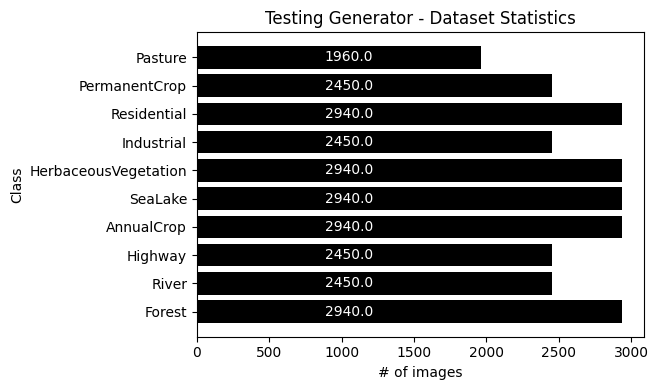

In [7]:
classes = dhandler.paths.keys()
loader  = datareader.generatorv2((x_t, y_t), (31,31,16))
test_loader.dlv2([x_t,y_t], loader, classes)

Reading Image:   0%|          | 0/540 [00:00<?, ?it/s]

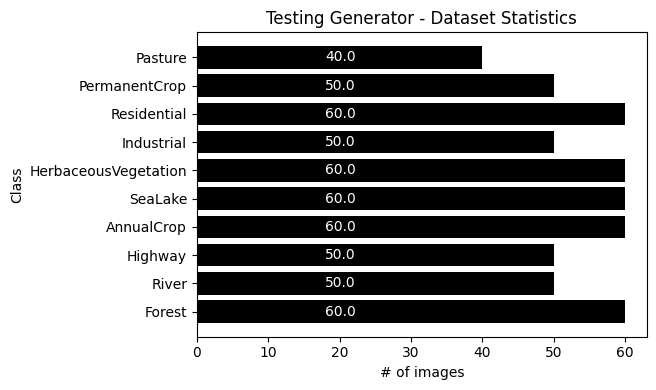

In [8]:
loader  = datareader.generatorv2((x_v, y_v), (31,31,16))
test_loader.dlv2([x_v,y_v], loader, classes)

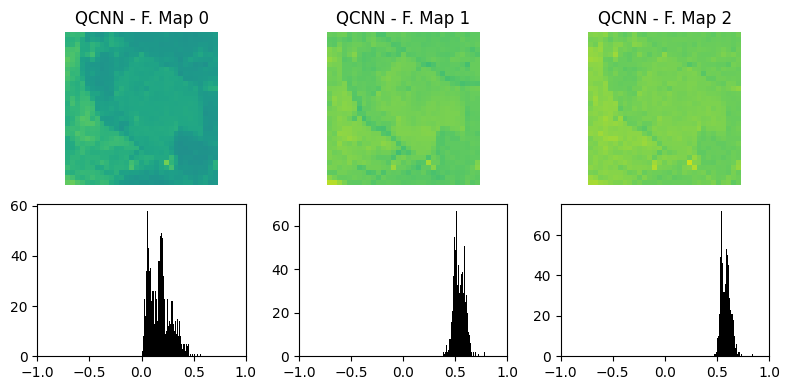

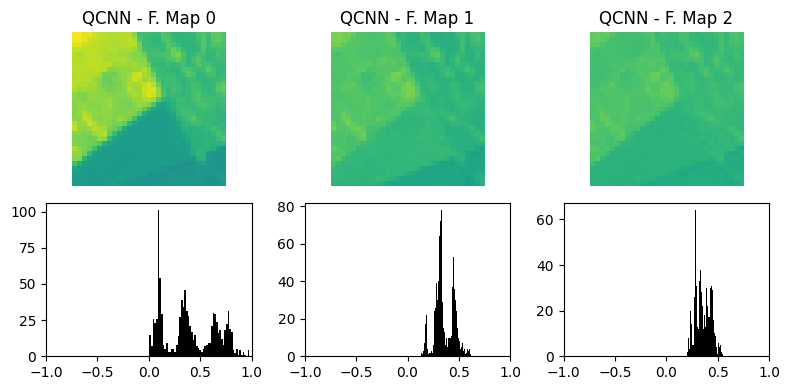

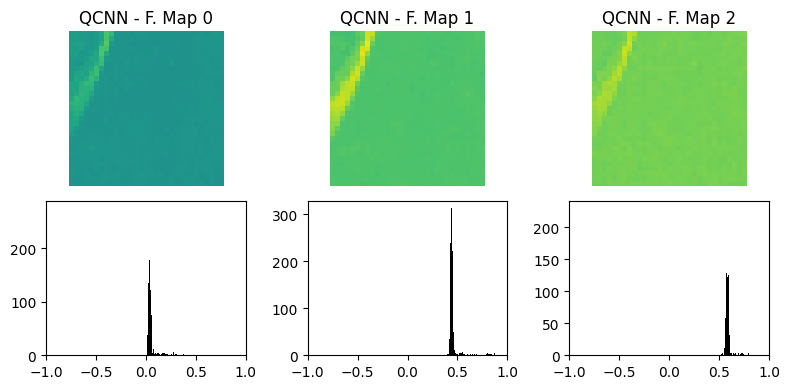

In [9]:
gen = iter(datareader.generator((x_t, y_t), 1, (31,31,16), normalize=True))
for i in range(3):
    (xi, yi) = next(gen)
    feat_maps = xi[0]
    plot_features_map(feat_maps)

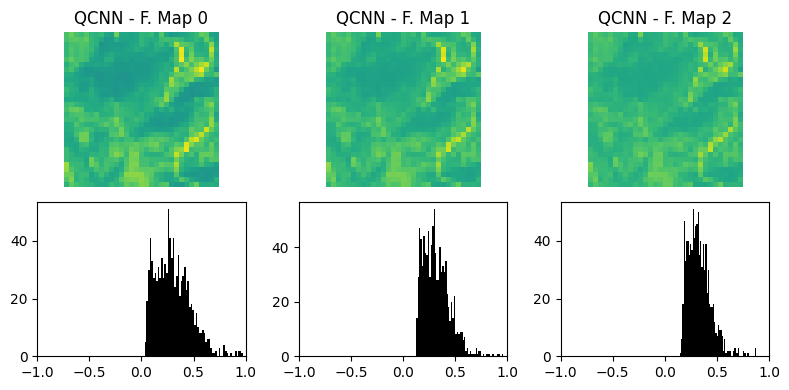

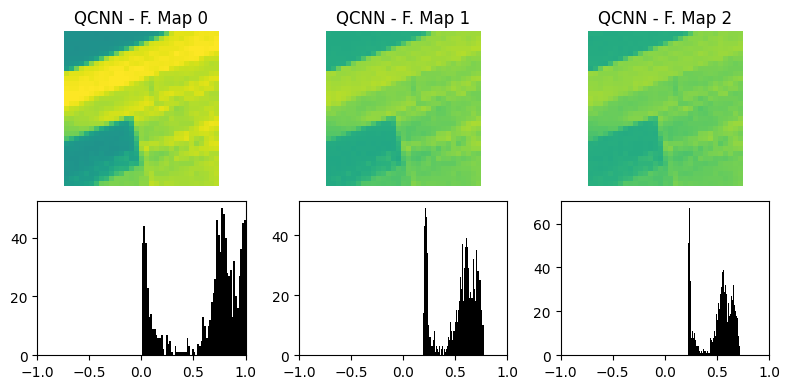

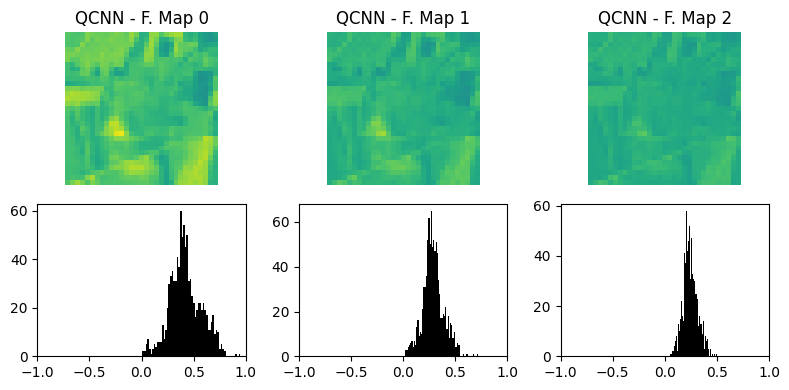

In [10]:
gen = iter(datareader.generator((x_v, y_v), 1, (31,31,16), normalize=True))
for i in range(3):
    (xi, yi) = next(gen)
    feat_maps = xi[0]
    plot_features_map(feat_maps)

## Hybrid Model

In [11]:
qcnn = QCNNv1(img_shape = (31,31,16), n_classes = 10)

In [12]:
qcnn.model.summary()

Model: "QCNNv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 31, 31, 3)]       0         
                                                                 
 activation (Activation)     (None, 31, 31, 3)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 300)               0         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                            

In [13]:
qcnn.train([x_t, y_t], [x_v, y_v], convert_labels_mapper(labels_mapper), normalize = True)

Epoch 1/2


2022-10-22 19:50:37.287946: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


33/33 [==============================] - 1s 14ms/step - loss: 2.3940 - accuracy: 0.1061 - val_loss: 2.1719 - val_accuracy: 0.1894
Epoch 2/2
33/33 [==============================] - 0s 11ms/step - loss: 2.2233 - accuracy: 0.2008 - val_loss: 2.0642 - val_accuracy: 0.2083
Model Saved                   results/QCNNv1/22-10-2022-19:50:38/model.h5
History Saved                 results/QCNNv1/22-10-2022-19:50:38/history.csv


  0%|          | 0/540 [00:00<?, ?it/s]

training Results              results/QCNNv1/22-10-2022-19:50:38/training-results.csv


  0%|          | 0/540 [00:00<?, ?it/s]

validation Results            results/QCNNv1/22-10-2022-19:50:38/validation-results.csv
